In [10]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from __future__ import annotations
import re
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import torch

# SAM1 (original)
from segment_anything import sam_model_registry, SamPredictor

In [6]:
!pip install -U ultralytics opencv-python matplotlib numpy torch segment_anything


Image: cdiradiologiamaraba.radiomemory.com.br_614734_38158.jpg
Teeth present (29): 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 41, 42, 43, 44, 45, 46, 47, 48
Teeth absent  (3): 28, 37, 38
JSON: yolo12_outputs/cdiradiologiamaraba.radiomemory.com.br_614734_38158_pred.json
Overlay: yolo12_outputs/cdiradiologiamaraba.radiomemory.com.br_614734_38158_pred.png
Image: cdiradiologiamaraba.radiomemory.com.br_645730_39836.jpg
Teeth present (14): 13, 14, 15, 17, 23, 24, 25, 27, 31, 32, 33, 41, 42, 43
Teeth absent  (18): 11, 12, 16, 18, 21, 22, 26, 28, 34, 35, 36, 37, 38, 44, 45, 46, 47, 48
JSON: yolo12_outputs/cdiradiologiamaraba.radiomemory.com.br_645730_39836_pred.json
Overlay: yolo12_outputs/cdiradiologiamaraba.radiomemory.com.br_645730_39836_pred.png
Image: cdiradiologiamaraba.radiomemory.com.br_678197_42927.jpg
Teeth present (23): 11, 12, 13, 15, 16, 17, 18, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 38, 41, 42, 43, 44, 45
Teeth absent  (9): 14, 24, 34, 35

KeyboardInterrupt: 

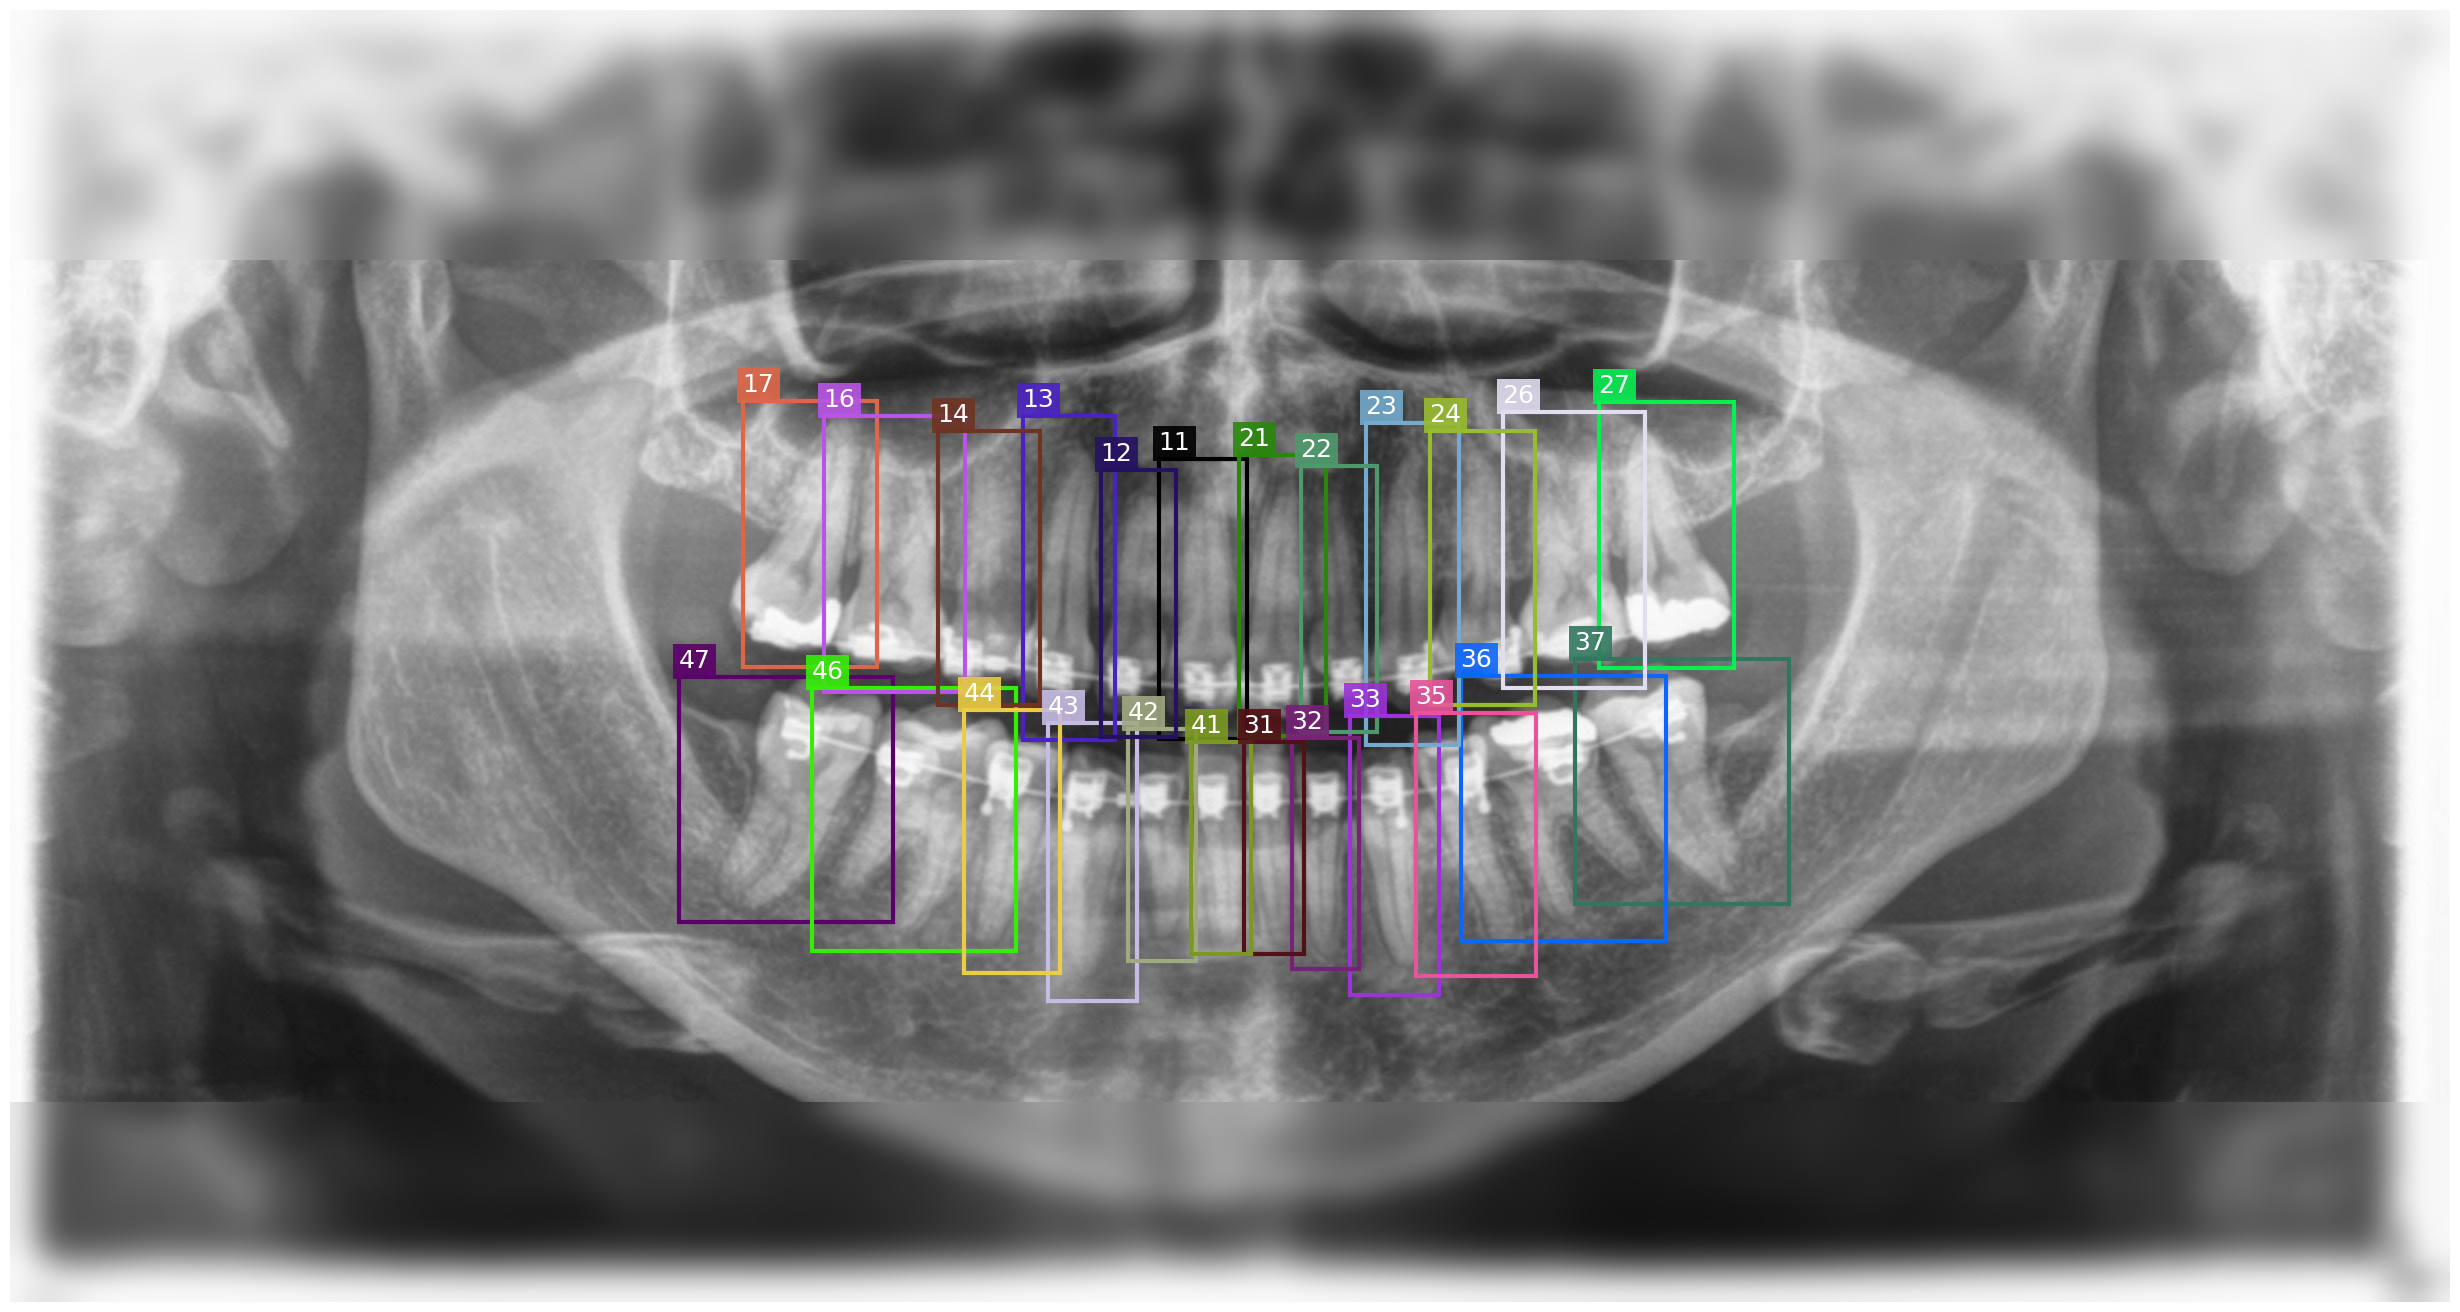

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
YOLOv12x Dental Detection Runner (Folder Inference)

What this script does
---------------------
1) Loads a YOLOv12x `.pt` checkpoint (Ultralytics).
2) Runs inference over *all images* inside a folder (optionally recursive).
3) Produces, for each image:
   - An optional overlay image with bounding boxes and FDI labels (no confidence in the label).
   - A JSON file containing:
       * image metadata (path, width, height)
       * teeth_present (FDI list)
       * teeth_absent  (FDI list)
       * detections (label, class_id, conf, bbox xyxy)

Assumptions
-----------
- Your model classes are indexed exactly as in LABEL_MAP (0..31 for FDI 11..48).
- Bounding boxes are returned in pixel coordinates (x1, y1, x2, y2).

Requirements
------------
pip install ultralytics opencv-python numpy matplotlib
"""

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Sequence, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO


# =========================
# Label mapping (FDI -> class_id)
# =========================
LABEL_MAP: Dict[str, int] = {
    "11": 0, "12": 1, "13": 2, "14": 3, "15": 4, "16": 5, "17": 6, "18": 7,
    "21": 8, "22": 9, "23": 10, "24": 11, "25": 12, "26": 13, "27": 14, "28": 15,
    "31": 16, "32": 17, "33": 18, "34": 19, "35": 20, "36": 21, "37": 22, "38": 23,
    "41": 24, "42": 25, "43": 26, "44": 27, "45": 28, "46": 29, "47": 30, "48": 31
}
FDI_ORDER: List[str] = list(LABEL_MAP.keys())
IDX_TO_FDI: Dict[int, str] = {v: k for k, v in LABEL_MAP.items()}

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}


# =========================
# Configuration
# =========================
@dataclass(frozen=True)
class Config:
    model_pt: Path
    source_dir: Path
    out_dir: Path

    conf_thres: float = 0.25
    iou_thres: float = 0.70
    imgsz: int = 1024
    device: str | None = None  # "0", "cpu", None

    recursive: bool = True
    save_overlay: bool = True
    save_json: bool = True

    overlay_ext: str = ".png"
    overlay_dpi: int = 200
    font_size: int = 18
    line_width: int = 3


# =========================
# Helpers
# =========================
def list_images(folder: Path, recursive: bool = True) -> List[Path]:
    """Return a sorted list of image files inside `folder`."""
    if not folder.exists():
        raise FileNotFoundError(f"Source folder not found: {folder}")
    if not folder.is_dir():
        raise ValueError(f"source_dir must be a directory. Got: {folder}")

    it = folder.rglob("*") if recursive else folder.glob("*")
    images = [p for p in it if p.is_file() and p.suffix.lower() in IMG_EXTS]
    images.sort()
    return images


def stable_color_rgb(class_id: int) -> Tuple[float, float, float]:
    """Deterministic RGB color in [0..1] for a class id."""
    r = ((class_id * 37) % 255) / 255.0
    g = ((class_id * 17) % 255) / 255.0
    b = ((class_id * 97) % 255) / 255.0
    return (r, g, b)


def draw_overlay_and_save(
    img_rgb: np.ndarray,
    detections: Sequence[dict],
    out_path: Path,
    *,
    dpi: int,
    font_size: int,
    line_width: int,
) -> None:
    """
    Save an overlay image with bounding boxes + FDI label (no confidence in text).
    Uses matplotlib.savefig as requested.
    """
    h, w = img_rgb.shape[:2]

    # Figure sized to the image; no borders/axes.
    fig = plt.figure(figsize=(w / 100.0, h / 100.0), dpi=100)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(img_rgb)
    ax.set_axis_off()

    for d in detections:
        x1, y1, x2, y2 = d["xyxy"]
        class_id = d["class_id"]
        label = d["label"]
        color = stable_color_rgb(class_id)

        rect = patches.Rectangle(
            (x1, y1),
            (x2 - x1),
            (y2 - y1),
            linewidth=line_width,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            max(0, y1 - 4),
            f"{label}",
            fontsize=font_size,
            color="white",
            verticalalignment="bottom",
            bbox=dict(facecolor=color, edgecolor="none", pad=4, alpha=0.90),
        )

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


def run_single_image(
    model: YOLO,
    img_path: Path,
    cfg: Config,
) -> dict | None:
    """
    Run YOLO inference on a single image and return a payload dict suitable for JSON output.
    Returns None if the image cannot be read.
    """
    # Inference (single image)
    results = model.predict(
        source=str(img_path),
        conf=cfg.conf_thres,
        iou=cfg.iou_thres,
        imgsz=cfg.imgsz,
        device=cfg.device,
        verbose=False,
    )

    r = results[0]
    boxes = r.boxes

    # Prefer orig_img if provided by Ultralytics; fallback to disk read.
    img_bgr = getattr(r, "orig_img", None)
    if img_bgr is None:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

    if img_bgr is None:
        print(f"[WARN] Could not read image: {img_path}")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]

    detections: List[dict] = []
    present_set = set()

    if boxes is not None and len(boxes) > 0:
        xyxy = boxes.xyxy.cpu().numpy()              # (N, 4)
        cls  = boxes.cls.cpu().numpy().astype(int)   # (N,)
        conf = boxes.conf.cpu().numpy()              # (N,)

        for (x1, y1, x2, y2), c, cf in zip(xyxy, cls, conf):
            label = IDX_TO_FDI.get(int(c), str(int(c)))

            # Only count as "present tooth" if the label is within our FDI map.
            if label in LABEL_MAP:
                present_set.add(label)

            detections.append({
                "label": label,
                "class_id": int(c),
                "conf": float(cf),
                "xyxy": [int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))],
            })

    teeth_present = [t for t in FDI_ORDER if t in present_set]
    teeth_absent  = [t for t in FDI_ORDER if t not in present_set]

    # Save overlay (optional)
    if cfg.save_overlay:
        out_img = cfg.out_dir / f"{img_path.stem}_pred{cfg.overlay_ext}"
        draw_overlay_and_save(
            img_rgb,
            detections,
            out_img,
            dpi=cfg.overlay_dpi,
            font_size=cfg.font_size,
            line_width=cfg.line_width,
        )

    payload = {
        "image": img_path.name,
        "image_path": str(img_path),
        "width": int(width),
        "height": int(height),
        "model": cfg.model_pt.name,
        "conf_thres": cfg.conf_thres,
        "iou_thres": cfg.iou_thres,
        "imgsz": cfg.imgsz,
        "teeth_present": teeth_present,
        "teeth_absent": teeth_absent,
        "detections": detections,
    }

    # Save JSON (optional)
    if cfg.save_json:
        out_json = cfg.out_dir / f"{img_path.stem}_pred.json"
        out_json.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")

    # Console summary
    print("=" * 80)
    print(f"Image: {img_path.name}")
    print(f"Teeth present ({len(teeth_present)}): {', '.join(teeth_present) if teeth_present else '(none)'}")
    print(f"Teeth absent  ({len(teeth_absent)}): {', '.join(teeth_absent) if teeth_absent else '(none)'}")
    if cfg.save_json:
        print(f"JSON: {cfg.out_dir / (img_path.stem + '_pred.json')}")
    if cfg.save_overlay:
        print(f"Overlay: {cfg.out_dir / (img_path.stem + '_pred' + cfg.overlay_ext)}")

    return payload


def main() -> None:
    cfg = Config(
        model_pt=Path("models/yolo12x_teeth.pt"),
        source_dir=Path("ground_truth"),  # folder
        out_dir=Path("yolo12_outputs"),  # output folder
        conf_thres=0.25,
        iou_thres=0.70,
        imgsz=1024,
        device=None,
        recursive=True,
        save_overlay=True,
        save_json=True,
        overlay_ext=".png",
        overlay_dpi=200,
        font_size=18,
        line_width=3,
    )

    cfg.out_dir.mkdir(parents=True, exist_ok=True)

    images = list_images(cfg.source_dir, recursive=cfg.recursive)
    if not images:
        raise RuntimeError(f"No images found in: {cfg.source_dir}")

    model = YOLO(str(cfg.model_pt))

    for img_path in images:
        try:
            run_single_image(model, img_path, cfg)
        except Exception as e:
            print(f"[ERROR] Failed on {img_path.name}: {e}")


if __name__ == "__main__":
    main()


In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
YOLO (detections) + SAM1 (fine-tuned) segmentation from boxes

Pipeline per image
------------------
1) Read image
2) YOLO inference -> get bounding boxes (xyxy) + class ids
3) SAM1 predictor:
   - set_image(RGB)
   - predict masks for each box
4) Merge masks into a single binary mask and remove small connected components
5) Create an overlay (mask color + contours), optionally draw boxes/labels
6) Save overlay image

Notes
-----
- This script uses SAM1 (segment_anything), NOT HQ-SAM.
- The SAM checkpoint loader supports both:
  a) "official-like" checkpoint path passed to registry (checkpoint=...),
  b) fine-tuned checkpoints that are a plain state_dict or dict with key "model".
"""




# ──────────────────────────────────────────────
# LABEL MAP (FDI "11..48" → class index 0..31)
# ──────────────────────────────────────────────
LABEL_MAP: Dict[str, int] = {
    "11": 0,  "12": 1,  "13": 2,  "14": 3,  "15": 4,  "16": 5,  "17": 6,  "18": 7,
    "21": 8,  "22": 9,  "23": 10, "24": 11, "25": 12, "26": 13, "27": 14, "28": 15,
    "31": 16, "32": 17, "33": 18, "34": 19, "35": 20, "36": 21, "37": 22, "38": 23,
    "41": 24, "42": 25, "43": 26, "44": 27, "45": 28, "46": 29, "47": 30, "48": 31
}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
SHOW_INDEX_IN_TITLE = False


# ──────────────────────────────────────────────
# CONFIG
# ──────────────────────────────────────────────
IMG_DIR      = Path("dataset/report_images")
OUT_DIR      = Path("output_segmentation")

YOLO_WEIGHTS = Path("models/yolo12x_teeth.pt")

# SAM1 fine-tuned
SAM_MODEL_TYPE  = "vit_h"  # "vit_b" | "vit_l" | "vit_h"
SAM_WEIGHTS     = Path("models/sam_ft_best.pth")

CONF_THRESH = 0.6
DEVICE      = "cuda:0" if torch.cuda.is_available() else "cpu"

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Mask post-processing
MIN_AREA_THRESH = 200  # minimum component area in pixels

# Visualization
MULTIMASK  = True
ALPHA      = 0.3
MASK_COLOR = (255, 0, 0)  # BGR (blue-ish)

DRAW_BOXES  = False
DRAW_LABELS = False

# Label drawing style
FONT_FACE      = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE     = 1.2
FONT_THICKNESS = 2
LABEL_PAD_X    = 10
LABEL_PAD_Y    = 8
# ──────────────────────────────────────────────


def ensure_bgr(img: np.ndarray | None) -> np.ndarray | None:
    """Ensure the image is BGR uint8 (handle grayscale and BGRA)."""
    if img is None:
        return None
    if len(img.shape) == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 4:
        return cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return img


def bgr_to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    """Convert BGR -> RGB."""
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def list_images(img_dir: Path) -> List[Path]:
    """List all images in IMG_DIR (non-recursive)."""
    if not img_dir.exists():
        raise FileNotFoundError(f"IMG_DIR not found: {img_dir}")
    paths = [p for p in img_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    paths.sort()
    return paths


# -------------------------
# Model loading
# -------------------------
def load_yolo(weights: Path) -> YOLO:
    return YOLO(str(weights))


def load_sam1_predictor(model_type: str, ckpt_path: Path, device: str) -> SamPredictor:
    """
    Load SAM1 fine-tuned model.

    Supports:
    - ckpt_path being compatible with SAM registry "checkpoint=" loading
    - or being a fine-tuned torch checkpoint (state_dict or dict with key "model")
    """
    # Try the registry checkpoint path first (works for official-like checkpoints)
    try:
        sam = sam_model_registry[model_type](checkpoint=str(ckpt_path))
        sam.to(device)
        return SamPredictor(sam)
    except Exception:
        # Fallback: initialize model then load state_dict manually
        sam = sam_model_registry[model_type](checkpoint=None)
        ckpt = torch.load(str(ckpt_path), map_location="cpu")

        if isinstance(ckpt, dict) and "model" in ckpt and isinstance(ckpt["model"], dict):
            state_dict = ckpt["model"]
        elif isinstance(ckpt, dict):
            # could already be a state_dict-like dict
            state_dict = ckpt
        else:
            raise RuntimeError(f"Unsupported checkpoint format: {type(ckpt)}")

        missing, unexpected = sam.load_state_dict(state_dict, strict=False)
        if missing or unexpected:
            print(f"[SAM] load_state_dict(strict=False) -> missing={len(missing)}, unexpected={len(unexpected)}")

        sam.to(device)
        return SamPredictor(sam)


def load_models() -> Tuple[YOLO, SamPredictor]:
    yolo = load_yolo(YOLO_WEIGHTS)
    predictor = load_sam1_predictor(SAM_MODEL_TYPE, SAM_WEIGHTS, DEVICE)
    return yolo, predictor


# -------------------------
# SAM mask utilities
# -------------------------
def sam1_masks_from_boxes(
    predictor: SamPredictor,
    img_rgb: np.ndarray,
    boxes_xyxy: np.ndarray,
    multimask: bool = False,
) -> List[np.ndarray]:
    """
    Predict one mask per box using SAM1.
    Returns a list of uint8 masks (0/1).
    """
    predictor.set_image(img_rgb)
    masks_out: List[np.ndarray] = []

    for box in boxes_xyxy:
        box = np.asarray(box, dtype=np.float32)
        masks, scores, _ = predictor.predict(box=box, multimask_output=multimask)

        if multimask and scores is not None and len(scores) > 1:
            best_idx = int(np.argmax(scores))
            m = masks[best_idx]
        else:
            m = masks[0]

        masks_out.append(m.astype(np.uint8))

    return masks_out


def remove_small_regions(mask_bin_0_255: np.ndarray, min_area: int) -> np.ndarray:
    """
    Remove connected components with area < min_area.
    Input must be 0/255 uint8.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin_0_255, connectivity=8)
    cleaned = np.zeros_like(mask_bin_0_255)

    for i in range(1, num_labels):  # skip background 0
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned[labels == i] = 255

    return cleaned


def create_combined_binary_mask(image_shape: Tuple[int, ...], masks_list: List[np.ndarray]) -> np.ndarray:
    """
    OR-combine individual masks into a single 0/255 mask and remove small regions.
    """
    h, w = image_shape[:2]
    combined = np.zeros((h, w), dtype=np.uint8)

    for m in masks_list:
        if m is None:
            continue
        m2 = m.squeeze() if m.ndim == 3 else m
        combined = cv2.bitwise_or(combined, m2.astype(np.uint8))

    combined[combined > 0] = 255
    return remove_small_regions(combined, MIN_AREA_THRESH)


# -------------------------
# Visualization
# -------------------------
def apply_visual_overlay(
    image_bgr: np.ndarray,
    binary_mask_0_255: np.ndarray,
    boxes: np.ndarray | None = None,
    class_titles: List[str] | None = None,
    *,
    alpha: float = 0.5,
    draw_boxes: bool = False,
    draw_labels: bool = True,
) -> np.ndarray:
    """
    Overlay mask + contours, optionally draw YOLO boxes and labels.
    """
    overlay = image_bgr.copy()

    if binary_mask_0_255 is not None:
        color_layer = np.zeros_like(overlay, dtype=np.uint8)
        color_layer[:] = MASK_COLOR

        mask_bool = (binary_mask_0_255 > 0)
        overlay[mask_bool] = cv2.addWeighted(
            overlay[mask_bool], 1 - alpha, color_layer[mask_bool], alpha, 0
        )

        contours, _ = cv2.findContours(binary_mask_0_255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, MASK_COLOR, 2)

    if boxes is not None:
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = [int(v) for v in box]

            if draw_boxes:
                cv2.rectangle(overlay, (x1, y1), (x2, y2), MASK_COLOR, 2)

            if draw_labels and class_titles is not None and i < len(class_titles):
                label = str(class_titles[i])
                (tw, th), _ = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, FONT_THICKNESS)

                top = y1 - th - 2 * LABEL_PAD_Y
                bottom = y1
                if top < 0:
                    top = y1 + 2
                    bottom = top + th + 2 * LABEL_PAD_Y

                left = x1
                right = x1 + tw + 2 * LABEL_PAD_X

                cv2.rectangle(overlay, (left, top), (right, bottom), MASK_COLOR, -1)
                text_org = (left + LABEL_PAD_X, bottom - LABEL_PAD_Y)
                cv2.putText(
                    overlay, label, text_org,
                    FONT_FACE, FONT_SCALE, (0, 0, 0), FONT_THICKNESS, cv2.LINE_AA
                )

    return overlay


# -------------------------
# Label mapping helpers (unchanged logic)
# -------------------------
def name_to_fdi_code(name: str):
    s = str(name).strip()
    if re.fullmatch(r"\d{2}", s) and s in LABEL_MAP:
        return s
    if re.fullmatch(r"\d{1,2}", s):
        idx = int(s)
        if idx in INV_LABEL_MAP:
            return INV_LABEL_MAP[idx]
    nums = re.findall(r"\d+", s)
    if nums:
        last = nums[-1]
        if len(last) == 2 and last in LABEL_MAP:
            return last
        if len(last) <= 2:
            idx = int(last)
            if idx in INV_LABEL_MAP:
                return INV_LABEL_MAP[idx]
    return None


def map_titles(cls_ids, cls_names, show_index=False):
    titles = []
    for i in range(len(cls_ids)):
        code = None
        if cls_names is not None and i < len(cls_names):
            code = name_to_fdi_code(cls_names[i])

        if code is None:
            cid = int(cls_ids[i])
            if cid in INV_LABEL_MAP:
                code = INV_LABEL_MAP[cid]

        if code in LABEL_MAP:
            idx = LABEL_MAP[code]
            title = str(idx) if show_index else code
            titles.append(title)
        else:
            fallback_name = str(cls_names[i]) if (cls_names is not None and i < len(cls_names)) else str(cls_ids[i])
            titles.append(fallback_name)

    return titles


# -------------------------
# Main
# -------------------------
def main():
    yolo, predictor = load_models()

    img_paths = list_images(IMG_DIR)
    if not img_paths:
        print("No images found.")
        return

    OUT_DIR.mkdir(parents=True, exist_ok=True)

    for img_path in img_paths:
        print(f"[IMG] {img_path}")

        bgr = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        bgr = ensure_bgr(bgr)
        if bgr is None:
            print("  ! Could not read image. Skipping.")
            continue

        rgb = bgr_to_rgb(bgr)

        # 1) YOLO detection
        res = yolo.predict(source=str(img_path), conf=CONF_THRESH, device=DEVICE, verbose=False)[0]
        if res.boxes is None or len(res.boxes) == 0:
            print("  - No detections. Skipping.")
            continue

        boxes_xyxy = res.boxes.xyxy.cpu().numpy()
        cls_ids    = res.boxes.cls.cpu().numpy().astype(int).tolist()

        names_dict = getattr(res, "names", None)
        if not isinstance(names_dict, dict):
            try:
                names_dict = res.model.names
            except Exception:
                names_dict = {}

        cls_names = [names_dict[c] if c in names_dict else str(c) for c in cls_ids]

        # 2) SAM1 masks from YOLO boxes
        individual_masks = sam1_masks_from_boxes(
            predictor=predictor,
            img_rgb=rgb,
            boxes_xyxy=boxes_xyxy,
            multimask=MULTIMASK,
        )

        # 3) Combine + clean
        binary_mask_global = create_combined_binary_mask(bgr.shape, individual_masks)

        # 4) Overlay
        bb_titles = map_titles(cls_ids=cls_ids, cls_names=cls_names, show_index=SHOW_INDEX_IN_TITLE)

        painted = apply_visual_overlay(
            image_bgr=bgr,
            binary_mask_0_255=binary_mask_global,
            boxes=boxes_xyxy,
            class_titles=bb_titles,
            alpha=ALPHA,
            draw_boxes=DRAW_BOXES,
            draw_labels=DRAW_LABELS,
        )

        out_path = OUT_DIR / f"{img_path.stem}_overlay_sam1_clean.png"
        cv2.imwrite(str(out_path), painted)
        print(f"  + Saved overlay: {out_path}")


if __name__ == "__main__":
    main()


[IMG] dataset/report_images/roccampinas.radiomemory.com.br_316751_26620.jpg
  + Saved overlay: output_segmentation/roccampinas.radiomemory.com.br_316751_26620_overlay_sam1_clean.png
[IMG] dataset/report_images/roccampinas.radiomemory.com.br_316795_26625.jpg
  + Saved overlay: output_segmentation/roccampinas.radiomemory.com.br_316795_26625_overlay_sam1_clean.png
[IMG] dataset/report_images/roccampinas.radiomemory.com.br_316964_26639.jpg
  + Saved overlay: output_segmentation/roccampinas.radiomemory.com.br_316964_26639_overlay_sam1_clean.png
[IMG] dataset/report_images/roccampinas.radiomemory.com.br_317063_26648.jpg
  + Saved overlay: output_segmentation/roccampinas.radiomemory.com.br_317063_26648_overlay_sam1_clean.png
[IMG] dataset/report_images/roccampinas.radiomemory.com.br_317106_26651.jpg
  + Saved overlay: output_segmentation/roccampinas.radiomemory.com.br_317106_26651_overlay_sam1_clean.png
[IMG] dataset/report_images/roccampinas.radiomemory.com.br_317203_26656.jpg
  + Saved over